In [1]:
# model implementation
from ml.models.linear import LogisticRegression
from ml.algorithms.optimization import GradientDescent
from ml.models.statistical import GaussianDiscriminantAnalysis

# model selection
from ml.model_selection import GridSearchCV
from ml.functions.metrics.classification import F1Score, BinaryAccuracy
from ml.stats import ClassificationStats

# data manipulation
from ml.dataset import load_csv, split_train_test
from ml.algorithms.normalization import MinMaxScaler

import numpy as np
import matplotlib.pyplot as plt

np.random.seed(25)

## Q1, Q2 - Logistic Regression

### Load dataset

In [2]:
X, y = load_csv('./datasets/breastcancer.csv')
X_train, y_train, X_test, y_test = split_train_test(X, y, 0.8, shuffle=True)

### Find best hyperparameters for Logistic Regression with grid search and k-fold with k=10

In [3]:
grid = GridSearchCV(stats_generator=ClassificationStats)

for lambda_reg in [0.01, 0.001]:
    for alpha_lr in [0.1, 0.01]:
        
        print(f"LR candidate {len(grid.candidates)}: learning rate={alpha_lr}, regularization={lambda_reg}")        
        
        grid.add(LogisticRegression, {
            "solver": GradientDescent(epochs=4000, learning_rate=alpha_lr, regularization=lambda_reg, metrics=F1Score()),
            "dataScaler": MinMaxScaler})

best = grid.search(X_train, y_train, num_folds=10, score=F1Score(), score_minimize=False, shuffle=False)

LR candidate 0: learning rate=0.1, regularization=0.01
LR candidate 1: learning rate=0.01, regularization=0.01
LR candidate 2: learning rate=0.1, regularization=0.001
LR candidate 3: learning rate=0.01, regularization=0.001


### Train Logistic Regresion with our best hyperparameters

Best candidate: 2 - Learning rate: 0.1 - Regularization term: 0.001


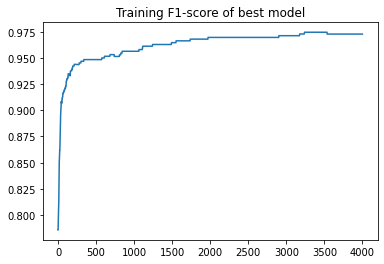

In [4]:
solver = grid.best_model_params['solver']
print("Best candidate:", grid.index_of_best, "- Learning rate:", solver.learning_rate, "- Regularization term:", solver.regularization)

model = grid.best_model(**grid.best_model_params)
training_score = model.fit(X_train, y_train)

plt.plot(training_score)
plt.title("Training F1-score of best model")
plt.show()

### Plot mean and standard deviation of F1-score, Accuracy, Recall and Precision during K-fold

In [12]:
num_candidates = len(grid.candidates)
k=0
plt.figure(figsize=(30, 4))
plt.suptitle("Logistic Regression", fontsize=20)
plt.subplots_adjust(top=0.7)
for metric in ['f1', 'recall', 'precision', 'binary_accuracy']:
    means = []
    std = []
    
    for i in range(num_candidates):
        means.append(np.mean(grid.stats[i].stats["values"][metric]))
        std.append(np.std(grid.stats[i].stats["values"][metric]))

    plt.subplot(1, 4, k+1)
    plt.errorbar(np.arange(num_candidates), means, std, fmt='ok', lw=3)
    plt.errorbar(grid.index_of_best, means[grid.index_of_best], std[grid.index_of_best], ecolor='red', fmt='ok', lw=3)
    
    plt.title(metric.upper() + " mean and std deviation", fontsize=20)
    plt.xticks(np.arange(num_candidates), labels=np.arange(num_candidates)+1)
    plt.xlabel("Candidate", fontsize=16)
    plt.ylabel(metric, fontsize=16)

    print(metric.upper(), "-", means, "+-", std)
    
    k+=1

NameError: name 'grid' is not defined

## Q1,Q2 - Gaussian Discriminant Analysis

### Load dataset

In [3]:
X, y = load_csv('./datasets/breastcancer.csv')

# Our gaussian discriminant analysis requires y to be integer and with shape (N,)
y = y.astype(int).squeeze()

X_train, y_train, X_test, y_test = split_train_test(X, y, 0.8, shuffle=True)

### Leverage our Grid Search with Cross-Validation class to run K-fold with k=10

In [6]:
grid_gda = GridSearchCV(stats_generator=ClassificationStats)
grid_gda.add(GaussianDiscriminantAnalysis, {})
grid_gda.search(X_train, y_train, num_folds=10, score=BinaryAccuracy(), score_minimize=False, shuffle=False)

### Train GDA and present its accuracy

In [9]:
gda = grid_gda.best_model(**grid_gda.best_model_params)
gda.fit(X_train, y_train)

print("F1-score:", F1Score().measure(y_test, gda.predict(X_test)))
print("Accuracy:", BinaryAccuracy().measure(y_test, gda.predict(X_test)))

F1-score: 0.9714285714285714
Accuracy: 0.9649122807017544


### Plot mean and standard deviation of F1-score, Accuracy, Recall and Precision during K-fold

F1 - [0.9654765004207851] +- [0.022148816199022658]
RECALL - [0.9629119798882195] +- [0.02710718473778025]
PRECISION - [0.969204928348151] +- [0.03598416211218145]
BINARY_ACCURACY - [0.9559903381642512] +- [0.029495869222608575]


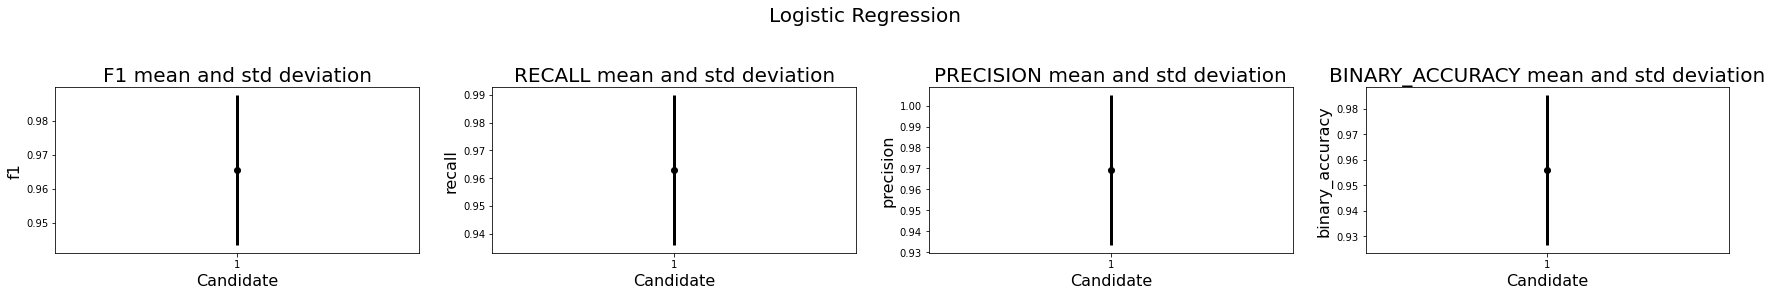

In [11]:
num_candidates = len(grid_gda.candidates)
k=0
plt.figure(figsize=(30, 4))
plt.suptitle("Logistic Regression", fontsize=20)
plt.subplots_adjust(top=0.7)
for metric in ['f1', 'recall', 'precision', 'binary_accuracy']:
    means = []
    std = []
    
    for i in range(num_candidates):
        means.append(np.mean(grid_gda.stats[i].stats["values"][metric]))
        std.append(np.std(grid_gda.stats[i].stats["values"][metric]))

    plt.subplot(1, 4, k+1)
    plt.errorbar(np.arange(num_candidates), means, std, fmt='ok', lw=3)
    
    plt.title(metric.upper() + " mean and std deviation", fontsize=20)
    plt.xticks(np.arange(num_candidates), labels=np.arange(num_candidates)+1)
    plt.xlabel("Candidate", fontsize=16)
    plt.ylabel(metric, fontsize=16)
    
    k+=1

    print(metric.upper(), "-", means, "+-", std)

## Q1,Q2 - Gaussian Naive Bayes
### Load dataset